In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from game_environment import cache_directory_files, DataSlice
from scipy.stats import skew, kurtosis

In [ ]:
# load all training data
train_dir = "../US_Market_Data"
eval_dir = "../US_Market_Data/^GSPC"
num_prev_file = 5

train_cache = cache_directory_files(train_dir, exclude_sub_dir=eval_dir, num_prev_file = num_prev_file)
test_cache = cache_directory_files(eval_dir, num_prev_file = num_prev_file)


In [ ]:
def combine_data_dict_to_df(data_dict):
    """
    Convert a dict of filename -> DataSlice (with 5 numpy arrays) to a combined DataFrame
    Each DataSlice has fields: open, high, low, close, volume
    """
    dfs = []
    for data_slice in data_dict.values():
        # Convert NamedTuple to dict of arrays
        data_dict_arrays = data_slice._asdict()
        # Convert dict of arrays to DataFrame (rows = time steps)
        df = pd.DataFrame(data_dict_arrays)
        dfs.append(df)
    # Combine all files vertically
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df, dfs

# Convert train and test
train_df , train_data= combine_data_dict_to_df(train_cache)
test_df, test_data = combine_data_dict_to_df(test_cache)

print("Train DF shape:", train_df.shape)
print("Test DF shape:", test_df.shape)
print(f"Train Data len: {len(train_data)}, item type:{type(train_data[0])}")

In [ ]:
def create_independent_states_df(df: pd.DataFrame):
    """
    Construct agent-independent features from normalized ohlcv + time data.
    Assumptions:
      - 'open', 'high', 'low', 'close' are ratios vs market open (not logged)
      - 'volume' is ratio vs historical median volume (not logged)
      - 'time' is timedelta since market open, starting at 0
    """

    # logged ohlc ratios
    close_norm = np.log(df["close"])
    open_norm = np.log(df["open"])
    high_norm = np.log(df["high"])
    low_norm = np.log(df["low"])

    # dlogprice
    dlogprice = np.log(df["close"] / df["open"])

    # close-to-mid ratio
    close_to_mid = np.where(
        df["high"] != df["low"],
        2 * (df["close"] - (df["high"] + df["low"]) / 2) / (df["high"] - df["low"]),
        0.0
    )

    # intra-bar volatility proxy
    intrabar_vol = np.log(df["high"] / df["low"])

    # volume (already ratio, so just log)
    dlogvol = np.log(df["volume"])

    # time completion ratio
    total_time = df["time"].iloc[-1]
    time_completion = df["time"] / total_time

    # true range (tr) in representative space
    tr = np.zeros(len(df))
    prev_close = df["close"].values

    for t in range(len(df)):
        if t == 0:
            tr[t] = df["high"].iloc[t] - df["low"].iloc[t]  # initialization
        else:
            hl = df["high"].iloc[t] - df["low"].iloc[t]
            hc = abs(df["high"].iloc[t] - prev_close[t-1])
            lc = abs(df["low"].iloc[t] - prev_close[t-1])
            tr[t] = max(hl, hc, lc)

    tr = 100 * tr

    # assemble output
    df_out = pd.DataFrame({
        "close_norm": close_norm,
        "open_norm": open_norm,
        "high_norm": high_norm,
        "low_norm": low_norm,
        "dlogprice": dlogprice,
        "close_to_mid": close_to_mid,
        "intra_bar_vol": intrabar_vol,
        "dlogvolume": dlogvol,
        "time_completion": time_completion,
        "tr": tr
    })

    return df_out

ind_train_dfs = [create_independent_states_df(df) for df in train_data]
ind_test_dfs = [create_independent_states_df(df) for df in test_data]

ind_train_df = create_independent_states_df(train_df)
ind_test_df = create_independent_states_df(test_df)

In [ ]:
train_df.columns

In [ ]:
# Stack correlation matrices
corr_stack = np.stack([df.corr().values for df in ind_train_dfs])

# Compute statistics (signed)
corr_mean = np.mean(corr_stack, axis=0)
corr_pos1sigma = np.percentile(corr_stack, 84.13, axis = 0)   # mean + 1σ in normal distribution
corr_pos2sigma = np.percentile(corr_stack, 97.72, axis = 0)   # mean + 2σ
corr_neg1sigma = np.percentile(corr_stack, 15.8, axis = 0)   # mean - 1σ
corr_neg2sigma = np.percentile(corr_stack, 2.28, axis = 0)    # mean - 2σ


# Compute absolute values for plotting
corr_min_plot = np.abs(np.min(corr_stack, axis=0))
corr_max_plot = np.abs(np.max(corr_stack, axis=0))
corr_mean_plot = np.abs(corr_mean)
corr_median_plot = np.abs(np.median(corr_stack, axis=0))
pos_1sigma_plot = np.abs(corr_pos1sigma)
pos_2sigma_plot = np.abs(corr_pos2sigma)
neg_1sigma_plot = np.abs(corr_neg1sigma)
neg_2sigma_plot = np.abs(corr_neg2sigma)

features = ind_train_dfs[0].columns

fig, axes = plt.subplots(4, 2, figsize=(28, 46))
axes = axes.flatten()

sns.heatmap(corr_min_plot, ax=axes[0], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[0].set_title("Min correlation", fontsize=14)

sns.heatmap(corr_max_plot, ax=axes[1], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[1].set_title("Max correlation", fontsize=14)

sns.heatmap(corr_mean_plot, ax=axes[2], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[2].set_title("Mean correlation", fontsize=14)

sns.heatmap(corr_median_plot, ax=axes[3], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[3].set_title("Median correlation", fontsize=14)

sns.heatmap(pos_1sigma_plot, ax=axes[4], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[4].set_title("Mean + 1σ", fontsize=14)

sns.heatmap(pos_2sigma_plot, ax=axes[5], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[5].set_title("Mean + 2σ", fontsize=14)

sns.heatmap(neg_1sigma_plot, ax=axes[6], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[6].set_title("Mean - 1σ", fontsize=14)

sns.heatmap(neg_2sigma_plot, ax=axes[7], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[7].set_title("Mean - 2σ", fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
# --- Train correlation ---
corr_train = ind_train_df.corr().abs()

# --- Test correlation ---
corr_test = ind_test_df.corr().abs()

# --- Side-by-side heatmaps for train/test ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(corr_train, cmap="coolwarm", annot=True, fmt=".2f",
            xticklabels=ind_train_df.columns,
            yticklabels=ind_train_df.columns, ax=axes[0])
axes[0].set_title("Train Correlation (abs)", fontsize=14)

sns.heatmap(corr_test, cmap="coolwarm", annot=True, fmt=".2f",
            xticklabels=ind_test_df.columns,
            yticklabels=ind_test_df.columns, ax=axes[1])
axes[1].set_title("Test Correlation (abs)", fontsize=14)


In [ ]:

# compute per-dataset correlations between tr and intra_bar_vol
per_slice_corrs = []
for df in ind_train_dfs:
    c = df[['tr', 'intra_bar_vol']].corr().iloc[0,1]  # tr vs intra_bar_vol
    per_slice_corrs.append(c)

per_slice_corrs = np.array(per_slice_corrs)
print("n slices:", len(per_slice_corrs))
print("min, 25%, median, mean, 75%, max: ",
      np.min(per_slice_corrs), np.percentile(per_slice_corrs,25),
      np.median(per_slice_corrs), np.mean(per_slice_corrs),
      np.percentile(per_slice_corrs,75), np.max(per_slice_corrs))

# histogram of per-slice correlations
plt.figure(figsize=(6,4))
sns.histplot(per_slice_corrs, bins=30, kde=True)
plt.xlabel("Per-slice corr(tr, intra_bar_vol)")
plt.title("Distribution of per-slice correlations")
plt.tight_layout()
plt.show()

# scatter on full aggregated dataset
plt.figure(figsize=(6,6))
sns.scatterplot(x='intra_bar_vol', y='tr', data=ind_train_df, s=5, alpha=0.3)
plt.xlabel("intra_bar_vol (log high/low)")
plt.ylabel("tr")
plt.title(f"Full-dataset scatter: corr={ ind_train_df[['tr','intra_bar_vol']].corr().iloc[0,1]:.2f}")
plt.tight_layout()
plt.show()


Values to Keep: 

close norm, intrabar vol proxy, dlogprice, dlogvolume, time completion ratio, close to mid ratio


In [38]:
def create_compound_states_df(df: pd.DataFrame, L: int):
    """
    Compute compound (rolling-window) features from OHLCV data.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['open','high','low','close','volume','time'].
        Assumptions:
          - Prices are ratios vs market open (not logged).
          - Volume is ratio vs historical median volume (not logged).
          - Time is timedelta since market open, starting at 0.
    L : int
        Lookback period (window length).
        
    Returns
    -------
    df_out : pd.DataFrame
        DataFrame with compound features, aligned so first row is at index L-1.
    """
    # Base increments
    dlogprice = np.log(df["close"] / df["open"])
    dlogvolume = np.log(df["volume"])
    
    # Price trend: bounded measure of directional persistence
    price_trend = (
        dlogprice.rolling(L).sum() /
        dlogprice.abs().rolling(L).sum()
    )
    
    # Volume trend
    volume_trend = (
        dlogvolume.rolling(L).sum() /
        dlogvolume.abs().rolling(L).sum()
    )
    
    #Price Volume Trend
    price_volume = price_trend* volume_trend / (np.abs(price_trend * volume_trend))
    
    # Price Momemtum
    price_momemtum = dlogprice.rolling(L).sum()
    
    # Unscaled Momemtum
    unscaled_momemtum = dlogprice.abs().rolling(L).sum()
    
    # Volatility (std of returns)
    volatility = dlogprice.rolling(L).std()
        
    # Skewness
    skewness = dlogprice.rolling(L).apply(lambda x: skew(x, bias=False), raw=True)

    # Excess Kurtosis (Fisher definition, 0 for Gaussian)
    kurt = dlogprice.rolling(L).apply(lambda x: kurtosis(x, fisher=True, bias=False), raw=True)

    
    highs = df["high"].values
    lows = df["low"].values
    max_dd = []

    for t in range(L-1, len(df)):
        window_highs = highs[t-L+1:t+1]
        window_lows = lows[t-L+1:t+1]

        current_peak = window_highs[0]
        window_max_dd = 0.0

        for hi, lo in zip(window_highs, window_lows):
            current_peak = max(current_peak, hi)           # update running peak
            dd = np.log(current_peak) - np.log(lo)        # log drawdown
            window_max_dd = max(window_max_dd, dd)        # max drawdown in window

        max_dd.append(window_max_dd)

    max_dd = pd.Series(max_dd, index=df.index[L-1:])

    # Assemble output
    df_out = pd.DataFrame({
        "price_trend": price_trend,
        "price_volume": price_volume,
        # "momemtum":price_momemtum,
        "unscaled_momemtum":unscaled_momemtum,
        "volume_trend": volume_trend,
        # "volatility": volatility,
        "skew": skewness,
        "kurtosis": kurt,
        "max_drawdown": max_dd
    })
    
    # Drop initial rows with NaN (first L-1)
    df_out = df_out.dropna().reset_index(drop=True)
    
    return df_out

L = 15 # Lookback period
cmp_train_dfs = [create_compound_states_df(df, 15) for df in train_data]
cmp_test_dfs = [create_compound_states_df(df, 15) for df in test_data]


cmp_train_df = create_compound_states_df(train_df,L)
cmp_test_df = create_compound_states_df(test_df,L)

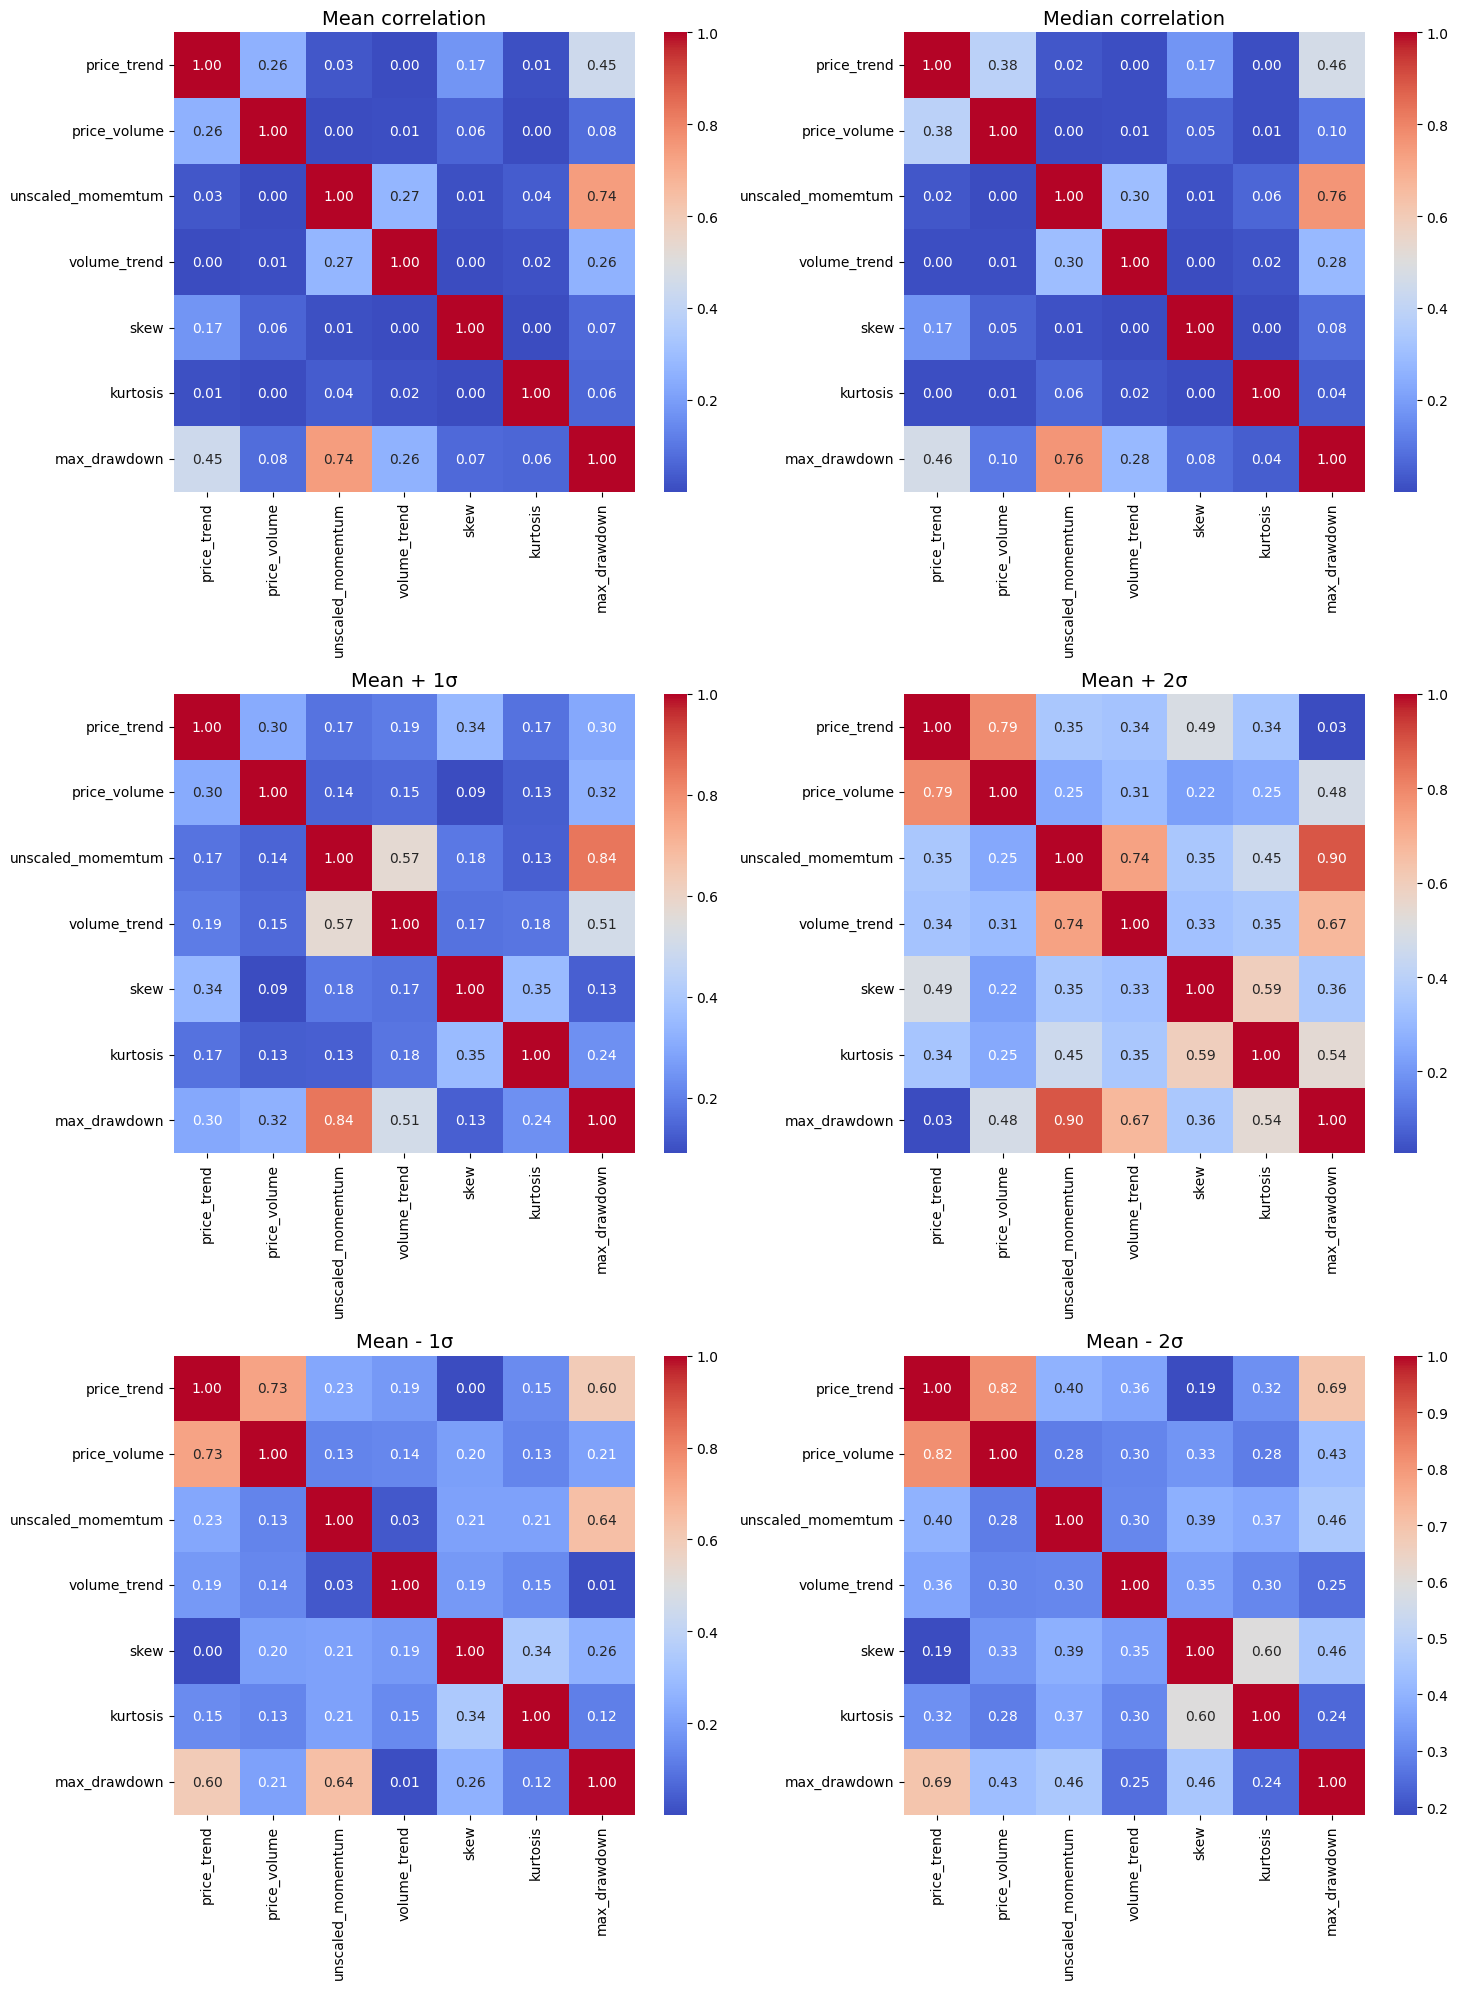

In [39]:
# Stack correlation matrices
corr_stack = np.stack([df.corr().values for df in cmp_train_dfs])

# Compute statistics (signed)
corr_mean = np.mean(corr_stack, axis=0)
corr_pos1sigma = np.percentile(corr_stack, 84.13, axis = 0)   # mean + 1σ in normal distribution
corr_pos2sigma = np.percentile(corr_stack, 97.72, axis = 0)   # mean + 2σ
corr_neg1sigma = np.percentile(corr_stack, 15.8, axis = 0)   # mean - 1σ
corr_neg2sigma = np.percentile(corr_stack, 2.28, axis = 0)    # mean - 2σ


# Compute absolute values for plotting
corr_mean_plot = np.abs(corr_mean)
corr_median_plot = np.abs(np.median(corr_stack, axis=0))
pos_1sigma_plot = np.abs(corr_pos1sigma)
pos_2sigma_plot = np.abs(corr_pos2sigma)
neg_1sigma_plot = np.abs(corr_neg1sigma)
neg_2sigma_plot = np.abs(corr_neg2sigma)

features = cmp_train_dfs[0].columns

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.flatten()

sns.heatmap(corr_mean_plot, ax=axes[0], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[0].set_title("Mean correlation", fontsize=14)

sns.heatmap(corr_median_plot, ax=axes[1], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[1].set_title("Median correlation", fontsize=14)

sns.heatmap(pos_1sigma_plot, ax=axes[2], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[2].set_title("Mean + 1σ", fontsize=14)

sns.heatmap(pos_2sigma_plot, ax=axes[3], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[3].set_title("Mean + 2σ", fontsize=14)

sns.heatmap(neg_1sigma_plot, ax=axes[4], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[4].set_title("Mean - 1σ", fontsize=14)

sns.heatmap(neg_2sigma_plot, ax=axes[5], cmap="coolwarm",
            xticklabels=features, yticklabels=features, annot=True, fmt=".2f")
axes[5].set_title("Mean - 2σ", fontsize=14)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Test Correlation (abs)')

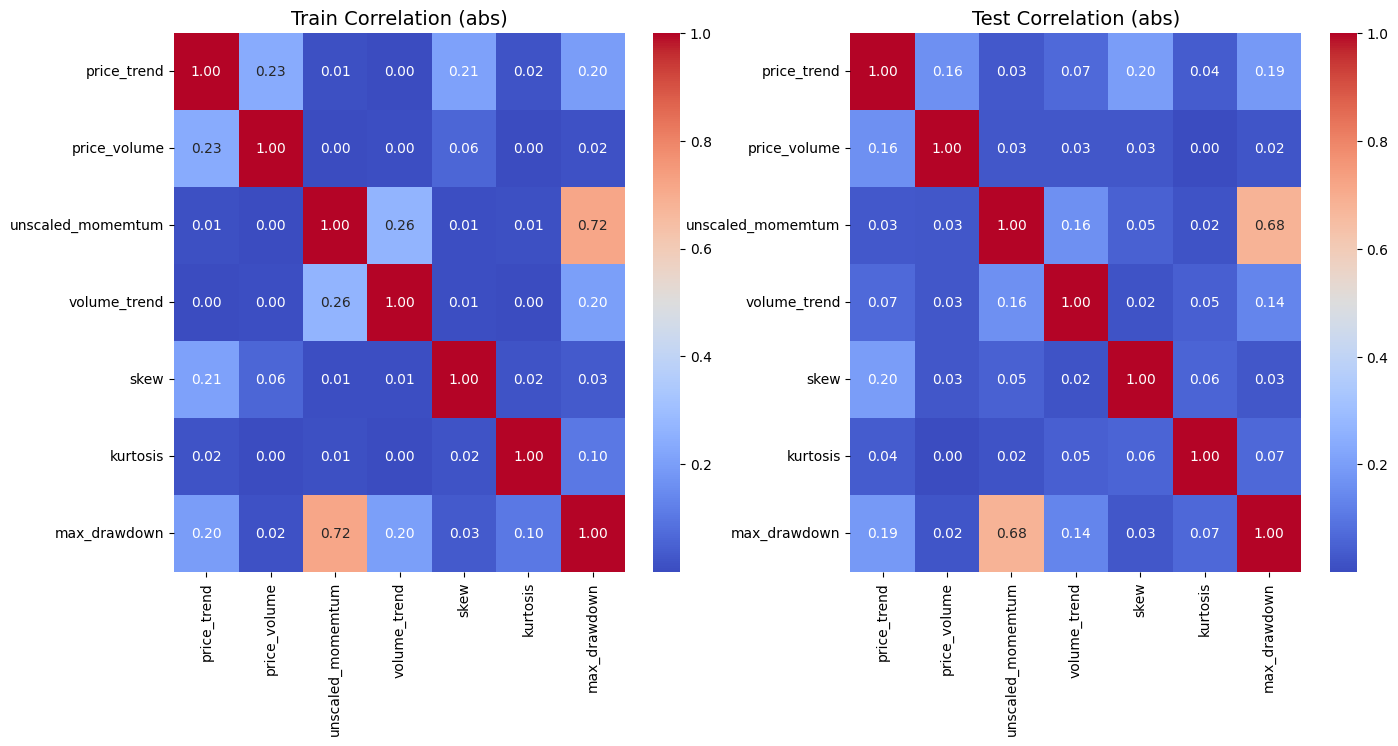

In [40]:
# --- Train correlation ---
corr_train = cmp_train_df.corr().abs()

# --- Test correlation ---
corr_test = cmp_test_df.corr().abs()

# --- Side-by-side heatmaps for train/test ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(corr_train, cmap="coolwarm", annot=True, fmt=".2f",
            xticklabels=cmp_train_df.columns,
            yticklabels=cmp_train_df.columns, ax=axes[0])
axes[0].set_title("Train Correlation (abs)", fontsize=14)

sns.heatmap(corr_test, cmap="coolwarm", annot=True, fmt=".2f",
            xticklabels=cmp_test_df.columns,
            yticklabels=cmp_test_df.columns, ax=axes[1])
axes[1].set_title("Test Correlation (abs)", fontsize=14)


Features to Keep:

Price Trend

Unscaled Momemtum (volatility proxy)

Volume Trend

Skew

Kurtosis

Max DrawDown